In [2]:
from os import listdir
from os.path import isfile, join
import pandas as pd
import tensorflow as tf
import cv2
import random
import numpy as np
import imageio
from tensorflow_docs.vis import embed
from pathlib import Path

In [3]:
len(tf.config.experimental.list_physical_devices('GPU'))>0

False

In [4]:
print(tf.config.list_physical_devices)

<function list_physical_devices at 0x0000029213EEE5F0>


In [5]:
#specify the path to the dataset
traindir = r"C:\Users\totol\Documents\dataset\train"
valdir = r"C:\Users\totol\Documents\dataset\val"

In [6]:
def extract_url_labels(dir):
    #create an empty pandas dataframe
    df = pd.DataFrame({'url': [], 'label': []})
    actions_dir = listdir(dir)
    for tmpdir in actions_dir:
        print(tmpdir)
        Lfiles = listdir(dir+"\\"+tmpdir)
        #print(Lfiles)
        for video in Lfiles:
            df.loc[len(df)] = [dir + "\\"+ tmpdir +"\\"+ video, tmpdir]
    return(df)


In [7]:
train_data =extract_url_labels(traindir)
train_data


applauding
cleaning toilet
doing nails
opening bottle (not wine)
petting cat
pillow fight
playing cards
playing guitar
smoking
stretching arm
washing dishes


,url,label
0,C:\Users\totol\Documents\dataset\train\applaud...,applauding
1,C:\Users\totol\Documents\dataset\train\applaud...,applauding
2,C:\Users\totol\Documents\dataset\train\applaud...,applauding
3,C:\Users\totol\Documents\dataset\train\applaud...,applauding
4,C:\Users\totol\Documents\dataset\train\applaud...,applauding
...,...,...
8696,C:\Users\totol\Documents\dataset\train\washing...,washing dishes
8697,C:\Users\totol\Documents\dataset\train\washing...,washing dishes
8698,C:\Users\totol\Documents\dataset\train\washing...,washing dishes
8699,C:\Users\totol\Documents\dataset\train\washing...,washing dishes


In [8]:
train_data=train_data.sample(frac=1).reset_index(drop=True)
train_data

,url,label
0,C:\Users\totol\Documents\dataset\train\doing n...,doing nails
1,C:\Users\totol\Documents\dataset\train\playing...,playing cards
2,C:\Users\totol\Documents\dataset\train\opening...,opening bottle (not wine)
3,C:\Users\totol\Documents\dataset\train\stretch...,stretching arm
4,C:\Users\totol\Documents\dataset\train\washing...,washing dishes
...,...,...
8696,C:\Users\totol\Documents\dataset\train\opening...,opening bottle (not wine)
8697,C:\Users\totol\Documents\dataset\train\petting...,petting cat
8698,C:\Users\totol\Documents\dataset\train\playing...,playing cards
8699,C:\Users\totol\Documents\dataset\train\washing...,washing dishes


In [9]:
val_data = extract_url_labels(valdir)
val_data

applauding
cleaning toilet
opening bottle (not wine)
petting cat
pillow fight
playing cards
smoking
stretching arm
vacuuming floor
washing dishes


,url,label
0,C:\Users\totol\Documents\dataset\val\applaudin...,applauding
1,C:\Users\totol\Documents\dataset\val\applaudin...,applauding
2,C:\Users\totol\Documents\dataset\val\applaudin...,applauding
3,C:\Users\totol\Documents\dataset\val\applaudin...,applauding
4,C:\Users\totol\Documents\dataset\val\applaudin...,applauding
...,...,...
481,C:\Users\totol\Documents\dataset\val\washing d...,washing dishes
482,C:\Users\totol\Documents\dataset\val\washing d...,washing dishes
483,C:\Users\totol\Documents\dataset\val\washing d...,washing dishes
484,C:\Users\totol\Documents\dataset\val\washing d...,washing dishes


In [10]:
val_data=val_data.sample(frac=1).reset_index(drop=True)
val_data

,url,label
0,C:\Users\totol\Documents\dataset\val\applaudin...,applauding
1,C:\Users\totol\Documents\dataset\val\opening b...,opening bottle (not wine)
2,C:\Users\totol\Documents\dataset\val\applaudin...,applauding
3,C:\Users\totol\Documents\dataset\val\washing d...,washing dishes
4,C:\Users\totol\Documents\dataset\val\pillow fi...,pillow fight
...,...,...
481,C:\Users\totol\Documents\dataset\val\pillow fi...,pillow fight
482,C:\Users\totol\Documents\dataset\val\opening b...,opening bottle (not wine)
483,C:\Users\totol\Documents\dataset\val\petting c...,petting cat
484,C:\Users\totol\Documents\dataset\val\petting c...,petting cat


In [11]:
print("nobre de vidéos au total (train+validation) : "+ str(len(train_data)+len(val_data)))

nobre de vidéos au total (train+validation) : 9187


In [12]:
def format_frames(frame, output_size):
  """
    Pad and resize an image from a video.
    
    Args:
      frame: Image that needs to resized and padded. 
      output_size: Pixel size of the output frame image.

    Return:
      Formatted frame with padding of specified output size.
  """
  frame = tf.image.convert_image_dtype(frame, tf.float32)
  frame = tf.image.resize_with_pad(frame, *output_size)
  return frame

In [13]:
def frames_from_video_file(video_path, n_frames, output_size = (244,244), frame_step = 15):
  """
    Creates frames from each video file present for each category.

    Args:
      video_path: File path to the video.
      n_frames: Number of frames to be created per video file.
      output_size: Pixel size of the output frame image.

    Return:
      An NumPy array of frames in the shape of (n_frames, height, width, channels).
  """
  # Read each video frame by frame
  result = []
  src = cv2.VideoCapture(str(video_path))  

  video_length = src.get(cv2.CAP_PROP_FRAME_COUNT)

  need_length = 1 + (n_frames - 1) * frame_step

  if need_length > video_length:
    start = 0
  else:
    max_start = video_length - need_length
    start = random.randint(0, max_start + 1)

  src.set(cv2.CAP_PROP_POS_FRAMES, start)
  # ret is a boolean indicating whether read was successful, frame is the image itself
  ret, frame = src.read()
  result.append(format_frames(frame, output_size))

  for _ in range(n_frames - 1):
    for _ in range(frame_step):
      ret, frame = src.read()
    if ret:
      frame = format_frames(frame, output_size)
      result.append(frame)
    else:
      result.append(np.zeros_like(result[0]))
  src.release()
  result = np.array(result)[..., [2, 1, 0]]

  return result

In [14]:
video_path=train_data['url'][400]
print(video_path)

C:\Users\totol\Documents\dataset\train\doing nails\kgSHSd5MGBM_000170_000180.mp4


In [15]:
sample_video = frames_from_video_file(video_path, n_frames = 10)
sample_video.shape

(10, 244, 244, 3)

In [16]:
def to_gif(images):
  converted_images = np.clip(images * 255, 0, 255).astype(np.uint8)
  imageio.mimsave('./animation.gif', converted_images, fps=10)
  return embed.embed_file('./animation.gif')


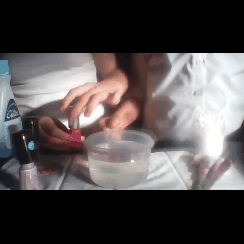

In [17]:
to_gif(sample_video)

In [18]:
class FrameGenerator:
    def __init__(self, data, n_frames, training=False):
        """Returns a set of frames with their associated label.

        Args:
            data: Pandas DataFrame containing the video URLs and labels.
            n_frames: Number of frames.
            training: Boolean to determine if training dataset is being created.
        """
        self.path = data['url']
        self.n_frames = n_frames
        self.training = training
        self.class_names = sorted(list(set(data['label'])))
        self.class_ids_for_name = dict((name, idx) for idx, name in enumerate(self.class_names))

    def get_files_and_class_names(self):
        video_paths = [Path(p) for p in self.path.astype(str).tolist() if p.endswith('.mp4')]
        classes = [p.parent.name for p in video_paths]
        return video_paths, classes

    def __call__(self):
        video_paths, classes = self.get_files_and_class_names()

        pairs = list(zip(video_paths, classes))

        if self.training:
            random.shuffle(pairs)

        for path, name in pairs:
            video_frames = frames_from_video_file(path, self.n_frames)
            label = self.class_ids_for_name[name]  # Encode labels
            yield video_frames, label

In [19]:
fg = FrameGenerator(train_data, 10, training=True)
frames, label = next(fg())

print(f"Shape: {frames.shape}")
print(f"Label: {label}")


Shape: (10, 244, 244, 3)
Label: 1


In [20]:
type(train_data)

pandas.core.frame.DataFrame